<a href="https://colab.research.google.com/github/kiran-pyt/Custom-Resnet/blob/main/firstcustomResent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
from torchsummary import summary
#from model import Net #Importing `Net` from model.py
from tqdm import tqdm
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

train_transforms = A.Compose(
    [
        A.Normalize(mean=means, std=stds, always_apply=True),
        A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
        A.RandomCrop(height=32, width=32, always_apply=True),
        A.HorizontalFlip(),
        A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=means),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.Normalize(mean=means, std=stds, always_apply=True),
        ToTensorV2(),
    ]
)

In [ ]:
class Cifar10SearchDataset(datasets.CIFAR10):

    def __init__(self, root="~/data", train=True, download=True, transform=None):

        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):

        image, label = self.data[index], self.targets[index]

        if self.transform is not None:

            transformed = self.transform(image=image)

            image = transformed["image"]

        return image, label

In [ ]:
train = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


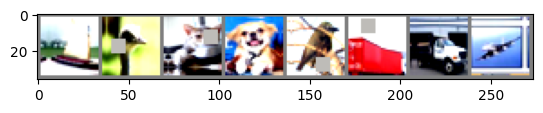

ship  bird  cat   dog  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:8]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.prep=nn.Sequential(nn.Conv2d(in_channels=3,out_channels=64,kernel_size=(3,3),stride=1,padding=1),
                                     nn.ReLU(),
                                     nn.BatchNorm2d(64)

                                     )
        self.layer1=nn.Sequential(nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),stride=1,padding=1),
                                  nn.MaxPool2d(2,2),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU()

                                  )

        self.resdiual1=nn.Sequential(nn.Conv2d(in_channels=128,out_channels=128,kernel_size=(3,3),stride=1,padding=1),
                                      nn.BatchNorm2d(128),
                                      nn.ReLU(),
                                      nn.Conv2d(in_channels=128,out_channels=128,kernel_size=(3,3),stride=1,padding=1),
                                      nn.BatchNorm2d(128),
                                      nn.ReLU(),

                                     )
        self.layer2=nn.Sequential(nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3),stride=1,padding=1),
                                  nn.MaxPool2d(2,2),
                                  nn.BatchNorm2d(256),
                                  nn.ReLU())

        self.layer3=nn.Sequential(nn.Conv2d(in_channels=256,out_channels=512,kernel_size=(3,3),stride=1,padding=1),
                                  nn.MaxPool2d(2,2),
                                  nn.BatchNorm2d(512),
                                  nn.ReLU())


        self.resdiual2=nn.Sequential(nn.Conv2d(in_channels=512,out_channels=512,kernel_size=(3,3),stride=1,padding=1),
                                      nn.BatchNorm2d(512),
                                      nn.ReLU(),
                                      nn.Conv2d(in_channels=512,out_channels=512,kernel_size=(3,3),stride=1,padding=1),
                                      nn.BatchNorm2d(512),
                                      nn.ReLU()
                                     )
        self.pool1=nn.MaxPool2d(4,4)

        self.fc1=nn.Linear(512,10)

        self.softmax = nn.Softmax()


    def forward(self,x):
        x=self.prep(x)
        r1=self.layer1(x)
        x=self.resdiual1(r1)
        x=x+r1

        x=self.layer2(x)

        r2=self.layer3(x)
        x=self.resdiual2(r2)
        x=x+r2
        x = self.pool1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.softmax(x)
        return x






In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

<ipython-input-9-4e1bef840cfe>:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


In [ ]:
def get_lr(optimizer):
    """"
    for tracking how your learning rate is changing throughout training
    """
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
lrs = []

def train(model, device, train_loader, optimizer, epoch, scheduler, criterion):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    train_losses.append(loss)
    lrs.append(get_lr(optimizer))

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} LR={get_lr(optimizer)} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

<ipython-input-9-4e1bef840cfe>:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.95E-02


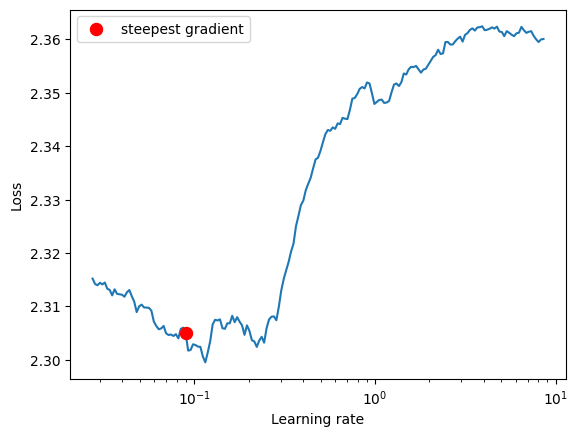

In [ ]:
from torch_lr_finder import LRFinder

model = Net().to(device)
optimizer = optim.Adam(model.parameters(),lr=0.02, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
!pip install torch-lr-finder

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 24

scheduler = OneCycleLR(
        optimizer,
        max_lr=8.95E-02,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, scheduler, criterion)
    test(model, device, test_loader, criterion)

EPOCH: 0


  0%|          | 0/98 [00:00<?, ?it/s]<ipython-input-9-4e1bef840cfe>:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)
Loss=2.0508522987365723 LR=0.018652239263803678 Batch_id=97 Accuracy=38.29: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s]



Test set: Average loss: 0.0043, Accuracy: 3225/10000 (32.25%)

EPOCH: 1


Loss=2.0075807571411133 LR=0.036409478527607356 Batch_id=97 Accuracy=41.80: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s]



Test set: Average loss: 0.0042, Accuracy: 3306/10000 (33.06%)

EPOCH: 2


Loss=2.020598888397217 LR=0.05416671779141104 Batch_id=97 Accuracy=42.56: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]



Test set: Average loss: 0.0042, Accuracy: 3704/10000 (37.04%)

EPOCH: 3


Loss=2.092764139175415 LR=0.0719239570552147 Batch_id=97 Accuracy=41.64: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]



Test set: Average loss: 0.0044, Accuracy: 2783/10000 (27.83%)

EPOCH: 4


Loss=2.0706582069396973 LR=0.08945193821160043 Batch_id=97 Accuracy=39.54: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]



Test set: Average loss: 0.0042, Accuracy: 3470/10000 (34.70%)

EPOCH: 5


Loss=2.047722339630127 LR=0.08474188294844254 Batch_id=97 Accuracy=39.41: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: 0.0045, Accuracy: 2140/10000 (21.40%)

EPOCH: 6


Loss=2.0293521881103516 LR=0.08003182768528463 Batch_id=97 Accuracy=41.27: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s]



Test set: Average loss: 0.0042, Accuracy: 3411/10000 (34.11%)

EPOCH: 7


Loss=2.00749135017395 LR=0.07532177242212675 Batch_id=97 Accuracy=43.08: 100%|██████████| 98/98 [00:20<00:00,  4.84it/s]



Test set: Average loss: 0.0042, Accuracy: 3485/10000 (34.85%)

EPOCH: 8


Loss=2.001293420791626 LR=0.07061171715896884 Batch_id=97 Accuracy=43.64: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: 0.0040, Accuracy: 4408/10000 (44.08%)

EPOCH: 9


Loss=1.960577130317688 LR=0.06590166189581095 Batch_id=97 Accuracy=45.36: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s]



Test set: Average loss: 0.0042, Accuracy: 3388/10000 (33.88%)

EPOCH: 10


Loss=2.0081357955932617 LR=0.06119160663265305 Batch_id=97 Accuracy=46.98: 100%|██████████| 98/98 [00:20<00:00,  4.79it/s]



Test set: Average loss: 0.0041, Accuracy: 4048/10000 (40.48%)

EPOCH: 11


Loss=1.9522098302841187 LR=0.05648155136949516 Batch_id=97 Accuracy=48.54: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s]



Test set: Average loss: 0.0041, Accuracy: 4225/10000 (42.25%)

EPOCH: 12


Loss=1.9179213047027588 LR=0.051771496106337266 Batch_id=97 Accuracy=49.56: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s]



Test set: Average loss: 0.0041, Accuracy: 4128/10000 (41.28%)

EPOCH: 13


Loss=1.978025197982788 LR=0.04706144084317937 Batch_id=97 Accuracy=50.36: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s]



Test set: Average loss: 0.0040, Accuracy: 4552/10000 (45.52%)

EPOCH: 14


Loss=1.9152368307113647 LR=0.042351385580021474 Batch_id=97 Accuracy=50.64: 100%|██████████| 98/98 [00:20<00:00,  4.84it/s]



Test set: Average loss: 0.0040, Accuracy: 4476/10000 (44.76%)

EPOCH: 15


Loss=1.9117907285690308 LR=0.037641330316863585 Batch_id=97 Accuracy=52.61: 100%|██████████| 98/98 [00:20<00:00,  4.83it/s]



Test set: Average loss: 0.0039, Accuracy: 5170/10000 (51.70%)

EPOCH: 16


Loss=1.928860068321228 LR=0.03293127505370569 Batch_id=97 Accuracy=53.66: 100%|██████████| 98/98 [00:20<00:00,  4.89it/s]



Test set: Average loss: 0.0038, Accuracy: 5396/10000 (53.96%)

EPOCH: 17


Loss=1.9134063720703125 LR=0.028221219790547786 Batch_id=97 Accuracy=54.29: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s]



Test set: Average loss: 0.0038, Accuracy: 5398/10000 (53.98%)

EPOCH: 18


Loss=1.904728889465332 LR=0.023511164527389897 Batch_id=97 Accuracy=55.55: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s]



Test set: Average loss: 0.0038, Accuracy: 5600/10000 (56.00%)

EPOCH: 19


Loss=1.9176099300384521 LR=0.018801109264231994 Batch_id=97 Accuracy=56.45: 100%|██████████| 98/98 [00:20<00:00,  4.79it/s]



Test set: Average loss: 0.0037, Accuracy: 5929/10000 (59.29%)

EPOCH: 20


Loss=1.8306018114089966 LR=0.014091054001074105 Batch_id=97 Accuracy=57.48: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s]



Test set: Average loss: 0.0038, Accuracy: 5821/10000 (58.21%)

EPOCH: 21


Loss=1.8640116453170776 LR=0.009380998737916216 Batch_id=97 Accuracy=58.96: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s]



Test set: Average loss: 0.0037, Accuracy: 6045/10000 (60.45%)

EPOCH: 22


Loss=1.8947060108184814 LR=0.004670943474758313 Batch_id=97 Accuracy=60.13: 100%|██████████| 98/98 [00:20<00:00,  4.84it/s]



Test set: Average loss: 0.0037, Accuracy: 6236/10000 (62.36%)

EPOCH: 23


Loss=1.8308274745941162 LR=-3.9111788399576186e-05 Batch_id=97 Accuracy=61.24: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s]



Test set: Average loss: 0.0036, Accuracy: 6351/10000 (63.51%)

